# Details of an Example Use Case

The example_BIDS.py file is a Python script that illustrates how the user would use the py_neuromodulation software. In this notebook, we take this example and go over it step by step, in order to give a better intuition behind each step.

We start with importing the necessary packages:

In [1]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if os.path.basename(SCRIPT_DIR) == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_stats
)
from sklearn import metrics, model_selection
import json
import matplotlib.pyplot as plt
import numpy as np


## Read BIDS data

The first step in any use case is loading the data. Here, we show how the user would load data that is stored in the BIDS format, using the function nm_IO.read_BIDS_data().

py_neuromodulation can perform feature estimation and decoding in other types of data, but the user is responsible for the loading step and for guaranteeing that all necessary information is provided. In the next steps we point out which information all datasets must contain in order to use the pipeline.

In [3]:
sub = "000"
ses = "right"
task = "force"
run = 3
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = os.path.join(SCRIPT_DIR, "data")

# Provide a path for the output data.
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives")

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

Extracting parameters from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-000/ses-right/ieeg/sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-000/ses-right/ieeg/sub-000_ses-right_task-force_run-3_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-000/ses-right/ieeg/sub-000_ses-right_space-mni_electrodes.tsv.


##  Define the channels

BIDS data is saved in BrainVision format, which consists of three separate files:

- A text header file (.vhdr) containing meta data
- A text marker file (.vmrk) containing information about events in the data
- A binary data file (.eeg) containing the voltage values of the EEG (or as in our case, iEEG)

The MNE-BIDS Python library reads this data and stores it in a MNE-Python Raw object.

This Raw object has as attribute the channel names, and as a method get_channel_types, that returns a list of channel type for each channel.

The Raw object also stores the measurement information in raw.info, where one can also access the bad channels, i.e, a list of noisy/broken channels, by name. These channels will by default be ignored by many processing steps.

__If the user insert by hand the list of channel names, their respective types and the information on which are the bad ones, any type of data can be used, not necessarily in the BIDS format.__

Here "SQUARED_ROTATION" is used as target channel. After feature estimation, this channel will be normalized and added in a time aligned manner to the features output csv file.

In [4]:
nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=("MOV_LEFT_CLEAN",),
)

```nm_channels``` is a pandas dataframe that stores all information about the channels: their names, before and after rereferencing, which type of rereferencing was done, whether they were used or not, if they were marked as targets, and if they were market as bad or bad channels.

In [5]:
nm_channels

,name,rereference,used,target,type,status,new_name
0,STN_RIGHT_0,STN_RIGHT_2,1,0,seeg,good,STN_RIGHT_0-STN_RIGHT_2
1,STN_RIGHT_1,STN_RIGHT_0,1,0,seeg,good,STN_RIGHT_1-STN_RIGHT_0
2,STN_RIGHT_2,STN_RIGHT_1,1,0,seeg,good,STN_RIGHT_2-STN_RIGHT_1
3,ECOG_RIGHT_0,average,1,0,ecog,good,ECOG_RIGHT_0-avgref
4,ECOG_RIGHT_1,average,1,0,ecog,good,ECOG_RIGHT_1-avgref
5,ECOG_RIGHT_2,average,1,0,ecog,good,ECOG_RIGHT_2-avgref
6,ECOG_RIGHT_3,average,1,0,ecog,good,ECOG_RIGHT_3-avgref
7,ECOG_RIGHT_4,average,1,0,ecog,good,ECOG_RIGHT_4-avgref
8,ECOG_RIGHT_5,average,1,0,ecog,good,ECOG_RIGHT_5-avgref
9,MOV_RIGHT,None,0,0,misc,good,MOV_RIGHT


## Feature Estimation

nm.Stream is where the magic happens. It is the class that handles all feature estimation steps. First we create an instance of that class, and then use the set_settings_fast_compute function to only select fft features and a minimal set of rereferencing, normalization, notch filtering and post processing normalization methods. Afterwards, we manually set some other features that we want to compute as `True`.

In [6]:
stream = nm.Stream(
    settings=None,
    nm_channels=nm_channels,
    path_grids=None,
    verbose=True,
)

stream.set_settings_fast_compute()
stream.settings["features"]["raw_hjorth"] = True
stream.settings["features"]["bandpass_filter"] = True
stream.settings["features"]["fft"] = True
stream.settings["features"]["sharpwave_analysis"] = True
stream.settings["features"]["fooof"] = True
stream.settings["features"]["nolds"] = False
stream.settings["features"]["bursts"] = True


# Additional sharpwave features
stream.settings["sharpwave_analysis_settings"]["sharpwave_features"][
        "width"
    ] = True
stream.settings["sharpwave_analysis_settings"]["sharpwave_features"][
    "decay_time"
] = True
stream.settings["sharpwave_analysis_settings"]["sharpwave_features"][
    "rise_time"
] = True
stream.settings["sharpwave_analysis_settings"]["sharpwave_features"][
    "rise_steepness"
] = True
stream.settings["sharpwave_analysis_settings"]["sharpwave_features"][
    "decay_steepness"
] = True

stream.settings["sharpwave_analysis_settings"]["sharpwave_features"][
    "slope_ratio"
] = True


stream.settings["sharpwave_analysis_settings"]["estimator"]["mean"] = [
    "width",
    "decay_time",
    "rise_time",
    "rise_steepness",
    "decay_steepness",
    "sharpness",
    "prominence",
    "interval",
    "slope_ratio",
]

stream.settings["sharpwave_analysis_settings"]["estimator"]["var"] = [
    "width",
    "decay_time",
    "rise_time",
    "rise_steepness",
    "decay_steepness",
    "sharpness",
    "prominence",
    "interval",
    "slope_ratio",
]

stream.settings["sharpwave_analysis_settings"]["estimator"]["max"] = [
    "sharpness",
    "prominence",
]


# for now we only look at the aperiodic component of fooof
stream.settings["fooof"]["periodic"]["center_frequency"] = False
stream.settings["fooof"]["periodic"]["band_width"] = False
stream.settings["fooof"]["periodic"]["height_over_ap"] = False

# If we also want to compute nolds features (‘NOnLinear measures for Dynamical Systems’), this is how to select the frequency bands:

stream.settings["nolds_features"]["data"]["frequency_bands"] = [
                "theta",
                "alpha",
                "low beta",
                "high gamma"]

stream.settings["postprocessing"]["feature_normalization"] = False
stream.settings["postprocessing"]["project_cortex"] = True
stream.settings["postprocessing"]["project_subcortex"] = False



All settings that the user can alter are defined within `py_neuromodulation/nm_settings.json`. The user can either alter that file to select their preffered settings, or access it through the dictionary in `stream.settings`.
In the cell below we print the settings selected that are going to be used in our analysis.

In [7]:
print(json.dumps(stream.settings, indent=2))

{
  "sampling_rate_features_hz": 10,
  "segment_length_features_ms": 1000,
  "preprocessing": {
    "raw_resampling": true,
    "raw_normalization": false,
    "re_referencing": true,
    "notch_filter": true,
    "preprocessing_order": [
      "raw_resampling",
      "notch_filter",
      "re_referencing"
    ]
  },
  "features": {
    "raw_hjorth": true,
    "return_raw": false,
    "bandpass_filter": true,
    "stft": false,
    "fft": true,
    "sharpwave_analysis": true,
    "coherence": false,
    "fooof": true,
    "nolds": false,
    "bursts": true,
    "linelength": false,
    "mne_connectiviy": false
  },
  "postprocessing": {
    "feature_normalization": false,
    "project_cortex": true,
    "project_subcortex": false
  },
  "raw_resampling_settings": {
    "resample_freq_hz": 1000
  },
  "raw_normalization_settings": {
    "normalization_time_s": 30,
    "normalization_method": {
      "mean": false,
      "median": false,
      "zscore": true,
      "zscore-median": false

__ATTENTION__: estimation of nolds features makes computation time much longer. If the user wants to estimate them
`stream.settings["features"]["nolds"]` needs to be set to `True`.

__With nolds features, 100ms of data takes around 29 seconds to be processed.__

In the cell below, if the user provides sfreq, line_noise, coord_list and coord_names, then there's no need for data in BIDS format.

In stream.run the data should also be manually inserted.

In [8]:
stream.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

Last batch took: 0.73 seconds
1.0 seconds of data processed
Last batch took: 0.64 seconds
1.1 seconds of data processed
Last batch took: 0.47 seconds
1.2 seconds of data processed
Last batch took: 0.59 seconds
1.3 seconds of data processed
Last batch took: 0.69 seconds
1.4 seconds of data processed
Last batch took: 0.48 seconds
1.5 seconds of data processed
Last batch took: 0.54 seconds
1.6 seconds of data processed
Last batch took: 0.77 seconds
1.7 seconds of 

As soon as the command stream.run() above is executed, the feature estimation step is done and the results are saved in the BIDS format into the /py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/ directory.

The features are in a file _FEATURES.csv
The used channels are stored in nm_channels.csv
The settings chosen are in _SETTINGS.json
Additional information that is not part of settings nor channels is stored in _SIDECAR.json



## Analysing results

We can now analyse the results of the feature estimation using the Feature_Reader class. All features are estimated for each channel. For now, we plot results for only one ECoG channel.

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/sub-000_ses-right_task-force_run-3/MOV_aligned_features_ch_ECOG_RIGHT_3-avgref_fft.png


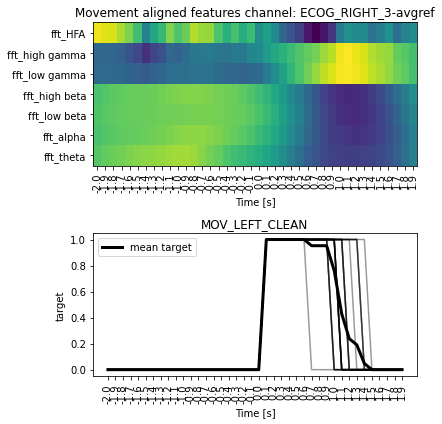

In [13]:
# init analyzer
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = feature_reader.nm_channels.query(
    '(type=="ecog") and (used == 1)'
).iloc[3]["new_name"]

feature_used = (
    "stft" if feature_reader.settings["features"]["stft"] else "fft"
)

feature_reader.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

In the first plot we see how the features change before, during and after movement. The time axis of the features is aligned to the target channel.

The function plot_target_averaged_channel() receives a threshold as optional input, for the case where the target is continuous, for example, a rotation movement. In that case, we need to threshold it somehow to get an "event", in which respect we can plot the features. For our case, it simplifies the problem to different classes and for t=0 a different class onsets, as we can see in the second plot, showing the target plotted for all events where it crossed the threshold.

The lighter plot is the individual movement trace, and the thicker one is the average.

The plot is saved as a .png in the /py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/ directory.

#### Plotting features over time

In [10]:
feature_reader.feature_arr.T

,0,1,2,3,4,5,6,7,8,9,...,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809
STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Activity,1562.615572,1650.862852,1652.156897,1410.534837,970.339813,628.690586,456.552839,438.706102,401.136619,401.089592,...,1547.495327,1570.278704,1604.510552,1951.264111,2083.793857,1798.192950,1700.842578,1809.998158,2007.403359,2135.888682
STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Mobility,0.130055,0.127515,0.126738,0.139946,0.170164,0.208200,0.246431,0.251803,0.257177,0.253924,...,0.136961,0.137704,0.136273,0.123139,0.117022,0.124521,0.125639,0.123614,0.119511,0.112163
STN_RIGHT_0-STN_RIGHT_2_RawHjorth_Complexity,9.268180,9.608271,9.608372,8.763054,7.173347,5.859031,4.956267,4.823281,4.736744,4.819226,...,8.969287,8.925862,8.999078,9.928769,10.369328,9.625863,9.520623,9.671950,10.031706,10.737261
STN_RIGHT_1-STN_RIGHT_0_RawHjorth_Activity,1309.885585,1459.539573,1544.130100,1693.945016,1862.482956,1973.255721,2108.811164,1925.862302,1201.165704,969.550953,...,980.737390,899.818141,777.330516,858.236732,980.814892,1043.874750,1074.548653,1118.555243,1233.950160,1378.475411
STN_RIGHT_1-STN_RIGHT_0_RawHjorth_Mobility,0.161999,0.155042,0.150164,0.144589,0.137783,0.133761,0.129243,0.135629,0.172156,0.189283,...,0.203175,0.212460,0.229955,0.215717,0.199145,0.193948,0.190561,0.188629,0.179966,0.166071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gridcortex_27_bursts_low gamma_in_burst,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.683831,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
gridcortex_28_bursts_low gamma_in_burst,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
gridcortex_32_bursts_low gamma_in_burst,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
time,1000.000000,1100.000000,1200.000000,1300.000000,1400.000000,1500.000000,1600.000000,1700.000000,1800.000000,1900.000000,...,281000.000000,281100.000000,281200.000000,281300.000000,281400.000000,281500.000000,281600.000000,281700.000000,281800.000000,281900.000000


Since the values for each feature are in very different scales, we make them comparable by z-scoring each feature separately. We use the `zscore` function from `nm_stats.py`.

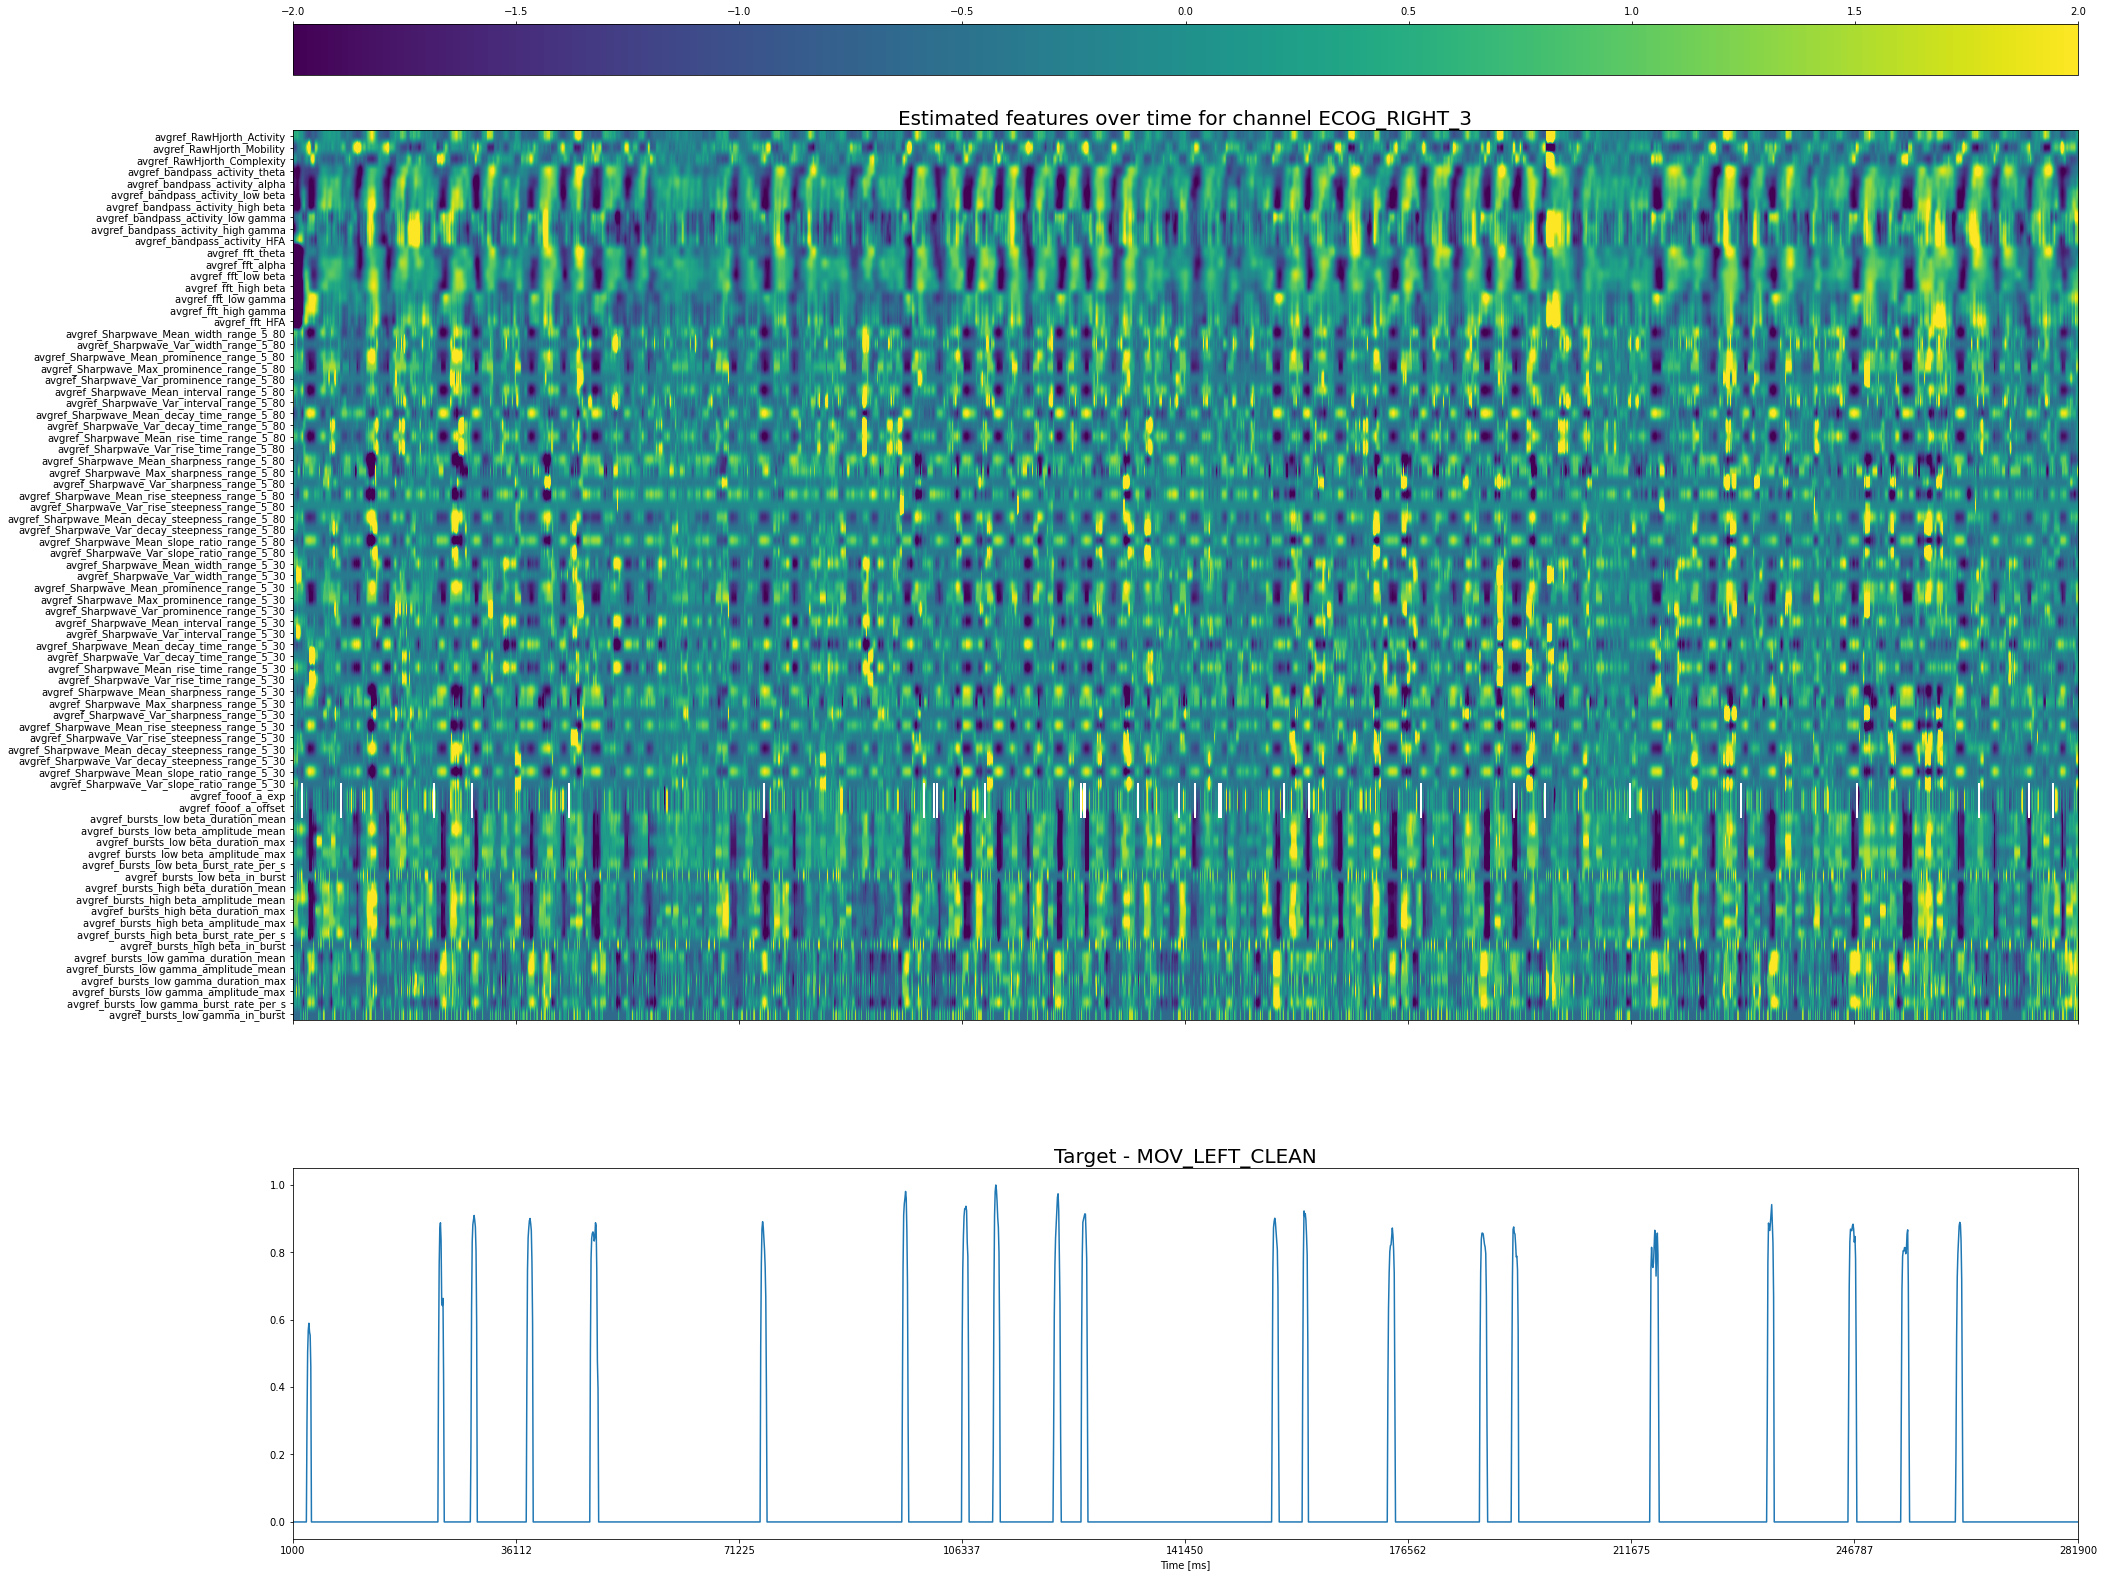

In [25]:
# We arbitrarily decided to plot the features from the first ECoG channel
ch_name = 'ECOG_RIGHT_3'
# In order to make nice labels in the y axis we do:
feature_names = list(feature_reader.feature_arr.filter(regex=ch_name)[:].columns)
df_first_ecog_ch = feature_reader.feature_arr.filter(regex=ch_name)
zscored_df = df_first_ecog_ch.apply(nm_stats.zscore, axis = 0)

feature_col_name = [
    i[len(ch_name) + 1 :] for i in feature_names if ch_name in i
]

fig, axs = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]}, figsize = (32,30), sharex=True )
# Here we remove the first data point from all features, because the normalization only starts in the second data point.

im = axs[0].imshow(zscored_df.T, aspect='auto', vmin = -2, vmax = 2)
axs[0].set_yticks(np.arange(0, len(feature_names), 1), feature_col_name)
x_labels_pos = np.linspace(0, len(feature_reader.feature_arr)-1, 9, dtype=int)
xlabels = list(np.linspace(feature_reader.feature_arr['time'].iloc[0], feature_reader.feature_arr['time'].iloc[-1], 9, dtype = int))
axs[0].set_xticks(x_labels_pos, xlabels)
axs[0].set_title("Estimated features over time for channel {}".format(ch_name), fontsize=20)
cbar = fig.colorbar(im, ax=axs[0], location = 'top', aspect = 35)

axs[1].plot(feature_reader.feature_arr["MOV_LEFT_CLEAN"])
axs[1].set_xticks(x_labels_pos, xlabels)
axs[1].set_xlabel("Time [ms]")
axs[1].set_title("Target - MOV_LEFT_CLEAN", fontsize=20);

### Correlation matrix of many features
It might also be useful to look at how features correlate with each other. Here, we can use the function ```plot_corr_matrix``` from ```nm_plots```.
Since we have too many features, let's plot only the features from the ECoG channel ```'ECOG_L_1_SMC_AT```.

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/sub-000_ses-right_task-force_run-3/Features_corr_matr_ch_ECOG_RIGHT_3-avgref.png


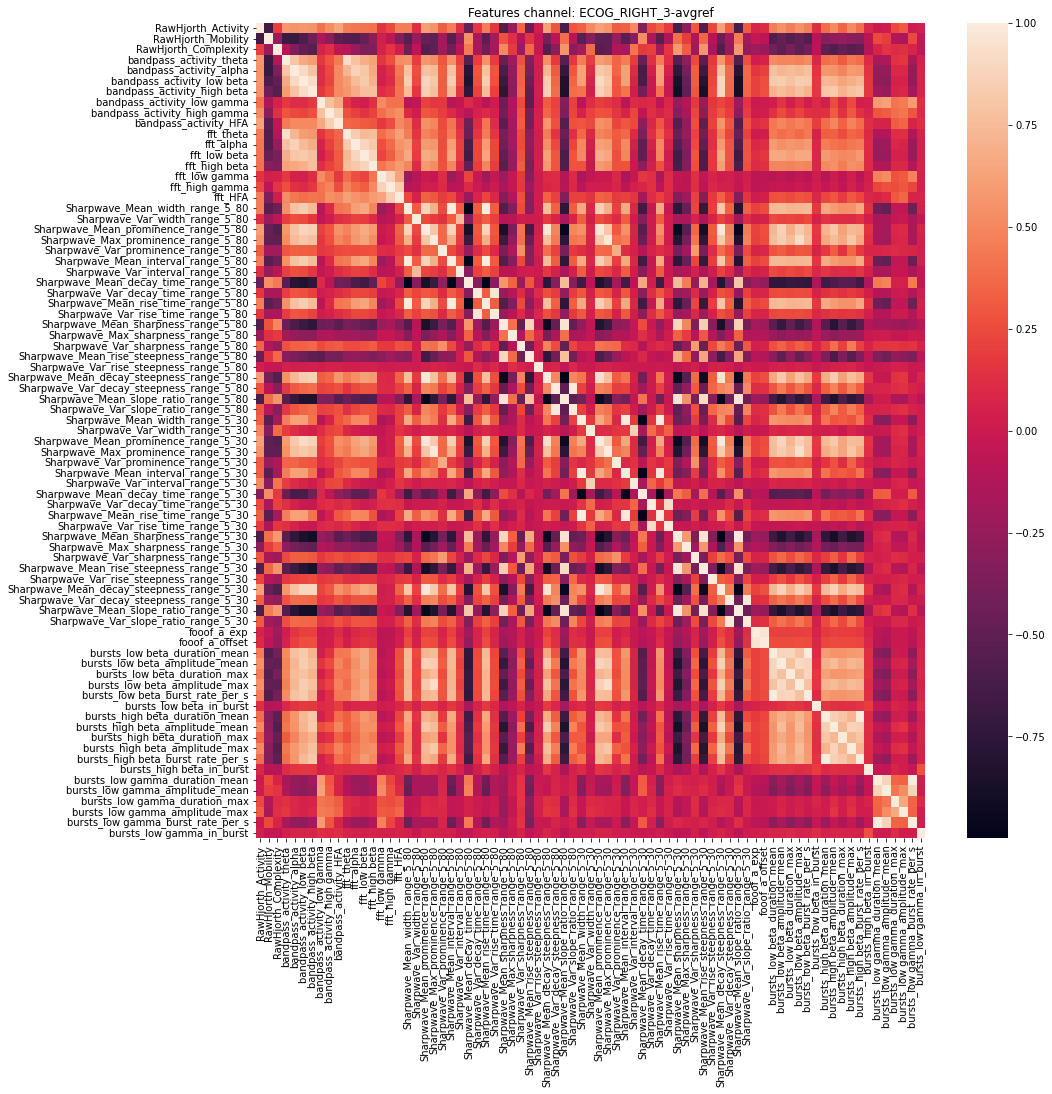

In [14]:
nm_plots.plot_corr_matrix(
        feature = feature_reader.feature_arr.filter(regex='ECOG_RIGHT_3-avgref'),
        ch_name= 'ECOG_RIGHT_3-avgref',
        OUT_PATH= PATH_OUT,
        feature_names=feature_reader.feature_arr.filter(regex='ECOG_RIGHT_3').columns,
        feature_file=feature_reader.feature_file,
        show_plot=True,
        figsize=(15,15),
)

## Decoding

The main focus of the py_neuromodulation pipeline is the feature estimation. Nevertheless, the user can also use the pipeline for Machine Learning decoding. It can be used for regression and classification problems, and also for unsupervised methods, such as PCA and CCA.

Here we show an example using the XGBOOST Classifier. The labels used come from the target, in this case, the "SQUARED_ROTATION".

The performance results are saved and plotted below. Again the figure is saved as a .png in the /py_neuromodulation/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/ directory.

model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_LM_ML_RES.p


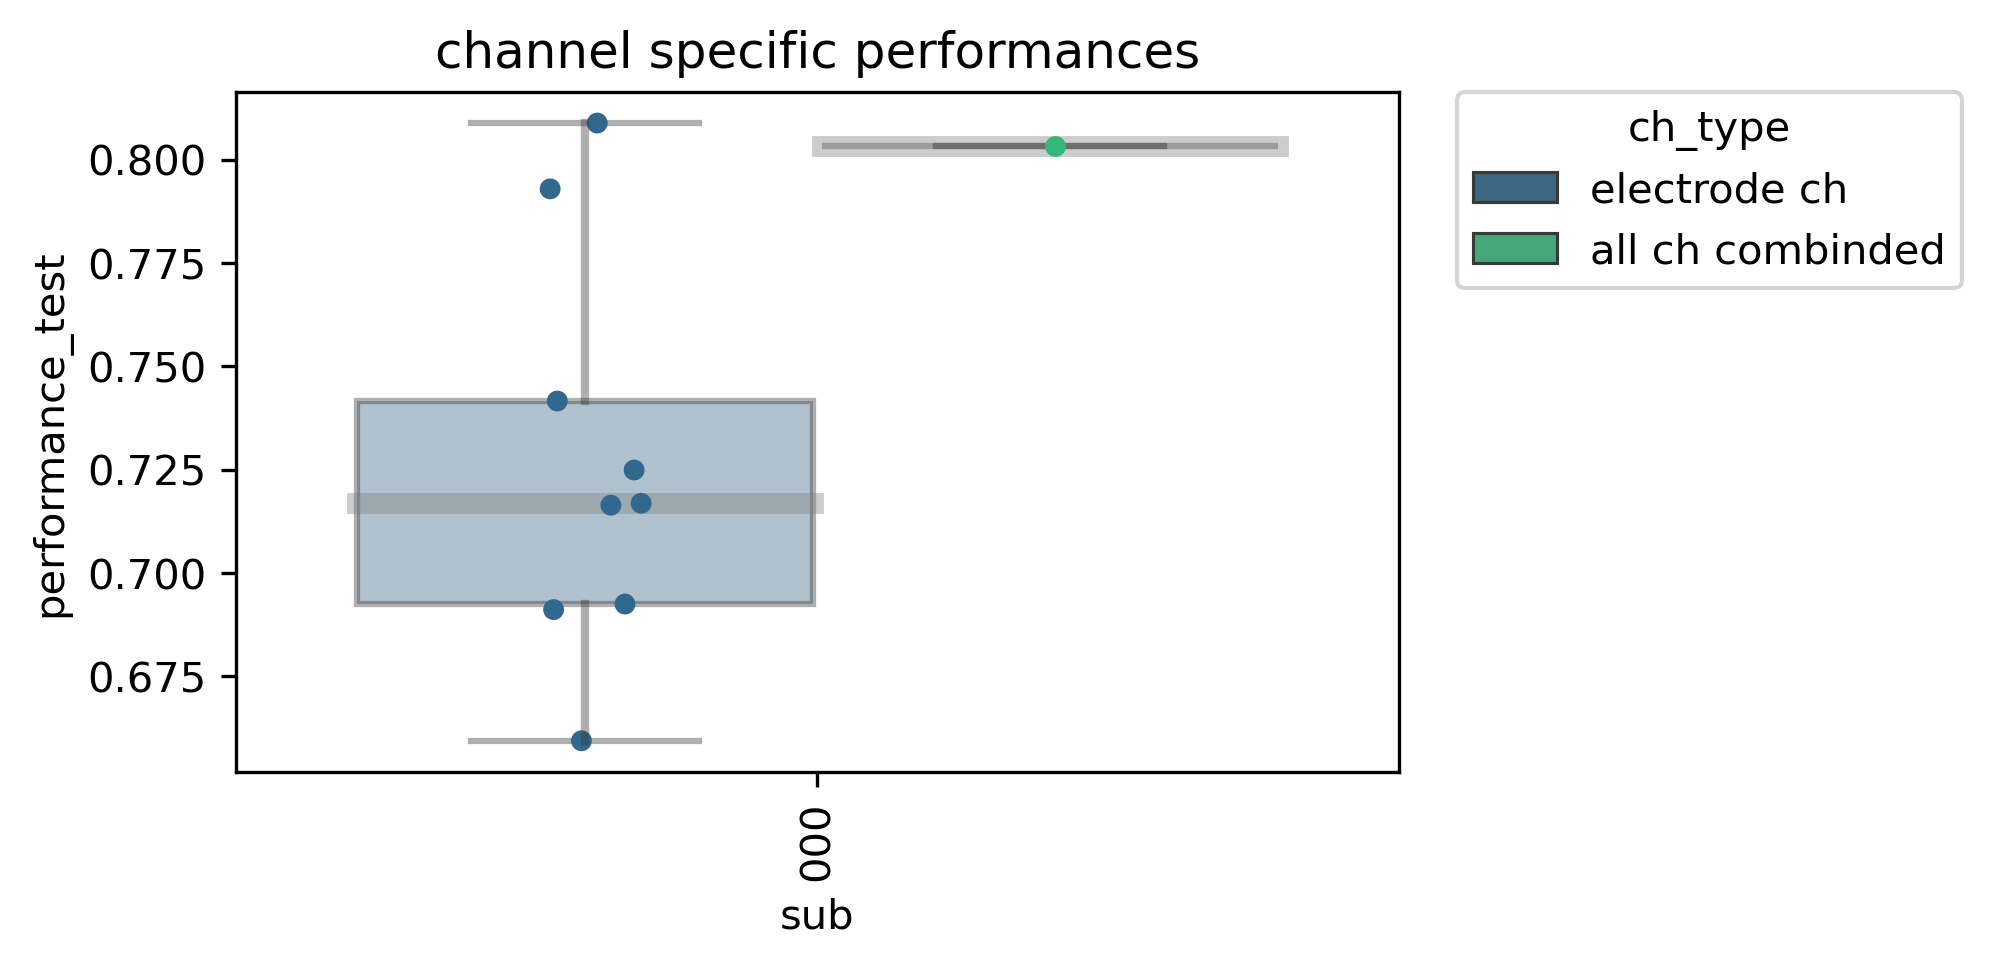

In [16]:
model = xgboost.XGBRegressor()

feature_reader.decoder = nm_decode.Decoder(
    features=feature_reader.feature_arr,
    label=feature_reader.label,
    label_name=feature_reader.label_name,
    used_chs=feature_reader.used_chs,
    model=model,
    eval_method=metrics.r2_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=False,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader.settings["sampling_rate_features_hz"],
)

performances = feature_reader.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per = feature_reader.get_dataframe_performances(performances)

nm_plots.plot_df_subjects(
    df_per, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT, RUN_NAME, RUN_NAME + "_decoding_performance.png")
)

### References

Holdgraf, C., Appelhoff, S., Bickel, S. et al. iEEG-BIDS, extending the Brain Imaging Data Structure specification to human intracranial electrophysiology. Sci Data 6, 102 (2019). https://doi.org/10.1038/s41597-019-0105-7

Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A., & Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software, 4:1896. DOI: 10.21105/joss.01896

https://www.brainproducts.com/support-resources/brainvision-core-data-format-1-0/